In [31]:
import pandas as pd
import numpy as np
import copy 
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import seaborn as sns

Feature Dataframe + Category Dataframe = Total DataFrame

In [32]:
feature_df = pd.read_csv('C:/Users/kiyeon/Desktop/SBD_project/result/pe_feature.csv')
trash_feature_list = [".dataSectionName", ".dataSectionVirtualSize", ".dataSection|VirtualSize-SizeOfRawData|", ".dataSectionVirtualAddress", ".dataSectionSizeOfRawData", ".dataSectionPointerToRawData", ".dataSectionCharacteristics", ".dataSectionEntropy"] # NaN밖에 없는 feature
for feature in trash_feature_list:
    feature_df.pop(feature)

category_df = pd.read_csv('C:/Users/kiyeon/Desktop/SBD_project/dataset/train_label.csv')

total_df = feature_df.join(category_df.set_index('File Name')['category'], on='File Name') # len(list(total_df)) == 62 = 1(file name) + 60(feature) + 1(category)
feature_list = list(feature_df)
feature_list.remove('File Name') # len(feature_list) == 60


text feature와 numeric feature의 list 만들기

In [33]:
txt_feature_list = ['.textSectionName', '.rsrcSectionName', '.rdataSectionName', '.relocSectionName']
numeric_feature_list = copy.deepcopy(feature_list)
for feature in txt_feature_list:
    numeric_feature_list.remove(feature) # final len(numeric_feature_list) == 56

text feature 결측값 처리: NaN과 단일값 밖에 없는 feature 처리 

In [34]:
# NaN이 있는 feature 찾기
nanexist_feature_list = []
for feature in feature_list:
    #print("Feature is: " + feature)
    if (total_df[feature].isnull().sum() != 0):
        nanexist_feature_list.append(feature)

# NaN이 있는 feature 중, 값이 단일값 또는 NaN만 있는 feature 찾기 -> 결국 text feature임
#for feature in nanexist_feature_list:
    #print("Feature is: " + feature)
    #print(set(total_df[feature].tolist())) # 해당 feature의 unique value 출력

# Replace the text feature NaN to 0, 단일값은 1로 대체
total_df = total_df.replace(to_replace=["b'.text\\x00\\x00\\x00'","b'.rsrc\\x00\\x00\\x00'","b'.rdata\\x00\\x00'","b'.reloc\\x00\\x00'"], value=1)
total_df[txt_feature_list] = total_df[txt_feature_list].fillna(0)

C:\Users\kiyeon\AppData\Local\Temp\ipykernel_14296\784801355.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  total_df = total_df.replace(to_replace=["b'.text\\x00\\x00\\x00'","b'.rsrc\\x00\\x00\\x00'","b'.rdata\\x00\\x00'","b'.reloc\\x00\\x00'"], value=1)


numerical feature 결측값 처리

In [35]:
for feature in numeric_feature_list:
    total_df[feature] = total_df[feature].fillna(total_df[feature].median())

feature의 stats

In [36]:
print("<Stats of entire features>")
total_df_stats = total_df.describe()
print(total_df_stats)

<Stats of entire features>
       e_magic     e_lfanew    e_minalloc        e_ovno  Signature  Machine  \
count   7633.0  7633.000000   7633.000000   7633.000000     7633.0   7633.0   
mean   23117.0   177.496659      8.825495   2285.481462    17744.0      0.0   
std        0.0    80.683810    346.020061   6701.929666        0.0      0.0   
min    23117.0    12.000000      0.000000      0.000000    17744.0      0.0   
25%    23117.0   128.000000      0.000000      0.000000    17744.0      0.0   
50%    23117.0   208.000000      0.000000      0.000000    17744.0      0.0   
75%    23117.0   248.000000      0.000000     26.000000    17744.0      0.0   
max    23117.0   712.000000  26723.000000  62222.000000    17744.0      0.0   

       NumberOfSections  TimeDateStamp  PointerToSymbolTable  NumberOfSymbols  \
count       7633.000000   7.633000e+03          7.633000e+03     7.633000e+03   
mean           5.067994   1.113862e+09          1.143799e+06     1.310686e+06   
std            2.8

Feature Scaling & Selection

In [37]:
## Scaling

total_df_scaled = copy.deepcopy(total_df)

for feature in numeric_feature_list:
    feature_min = total_df_stats.loc['min', feature]
    feature_max = total_df_stats.loc['max', feature]

    if (feature_min == feature_max):
        total_df_scaled[feature] = 1
    else:
        total_df_scaled[feature] = total_df[feature] / (feature_max - feature_min)

## Selection

selector = SelectKBest(f_classif, k=15)
selector.fit_transform(total_df_scaled[feature_list], total_df['category'])
selected_feature_idxs = selector.get_support(indices=True)
selected_feature_list = list(total_df_scaled[feature_list].iloc[:, selected_feature_idxs])
print("Selected features are:", selected_feature_list)

Selected features are: ['e_lfanew', 'e_ovno', 'TimeDateStamp', 'Characteristics', 'SizeOfImage', '.rsrcSectionVirtualAddress', '.rsrcSectionPointerToRawData', '.rsrcSectionEntropy', '.rdataSectionVirtualAddress', '.rdataSectionPointerToRawData', '.rdataSectionEntropy', '.relocSectionName', '.relocSectionVirtualSize', '.relocSectionVirtualAddress', 'TotalNumberOfFunctionInIAT']


c:\Users\kiyeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 0  4  5 23 25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\kiyeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


feature의 distribution visualization

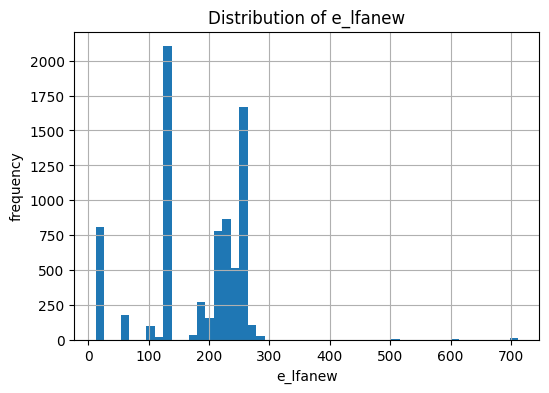

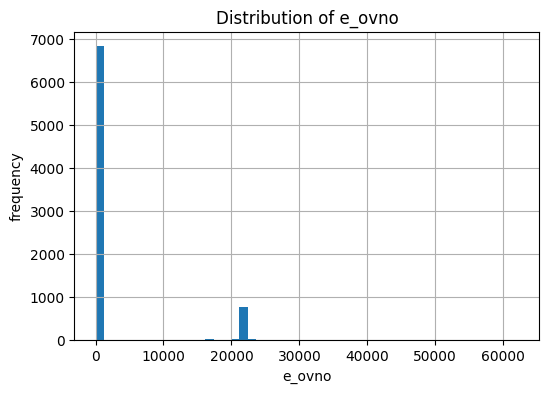

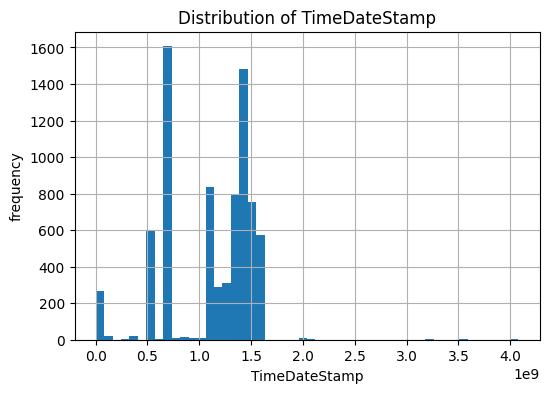

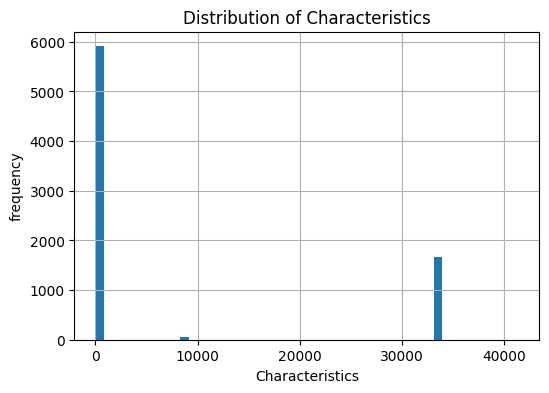

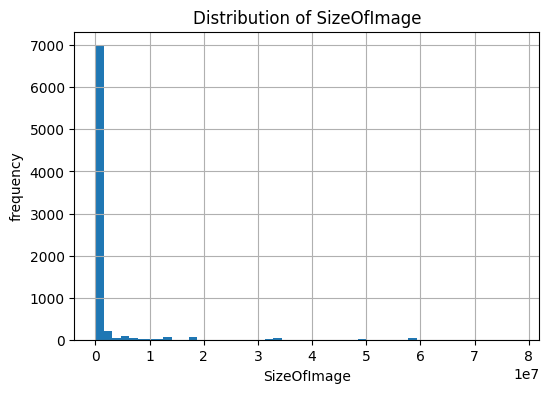

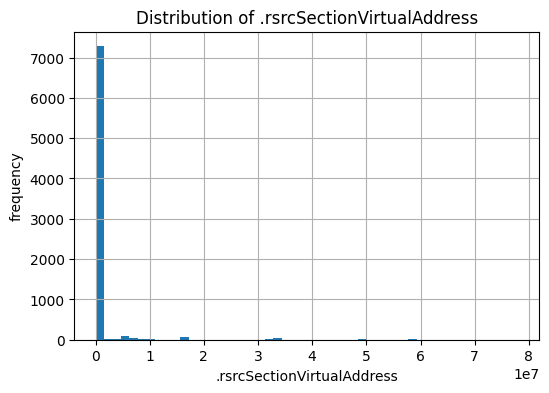

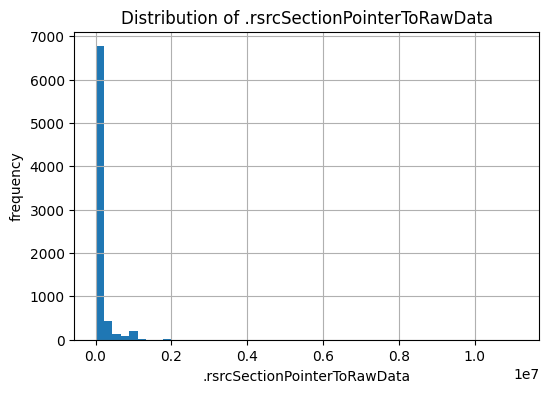

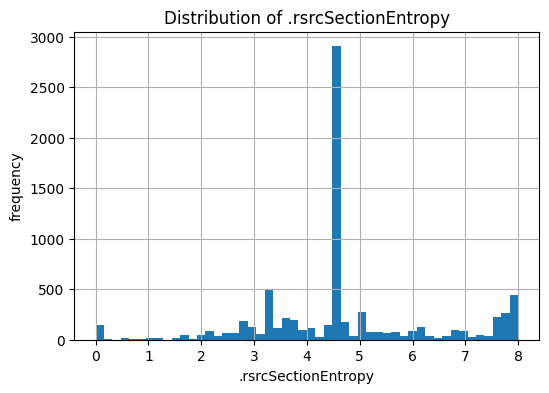

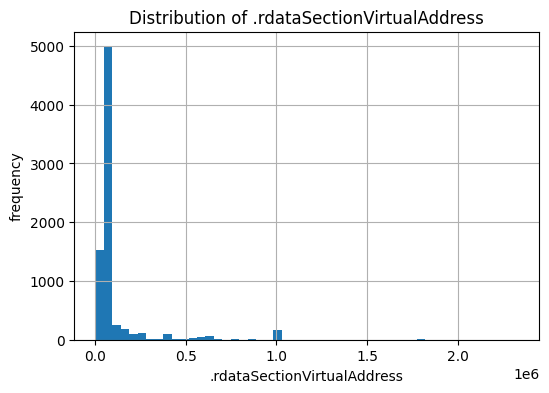

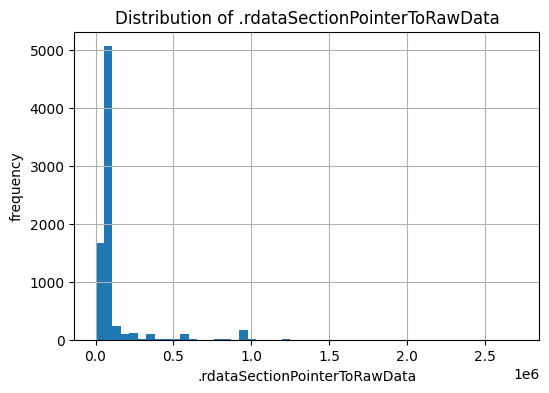

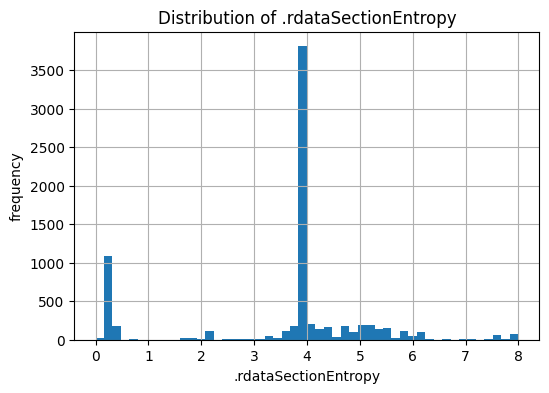

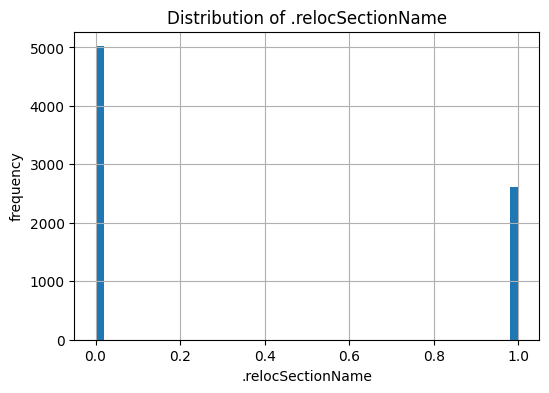

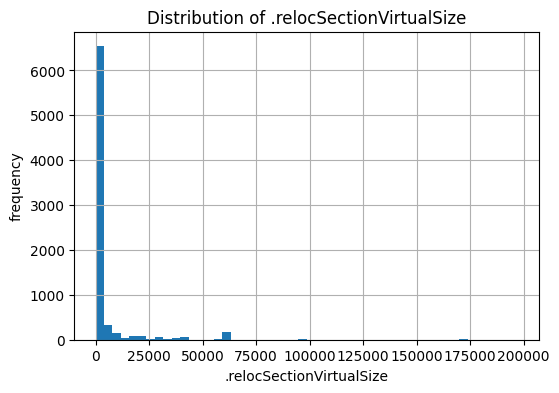

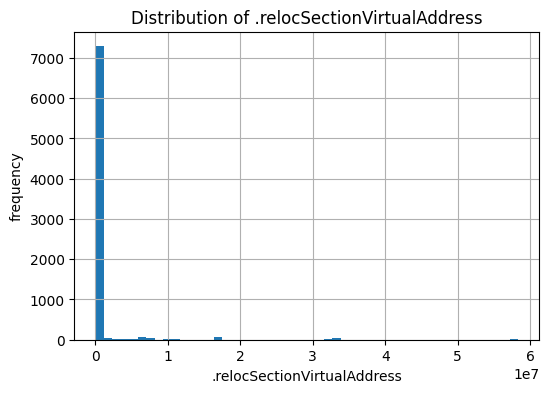

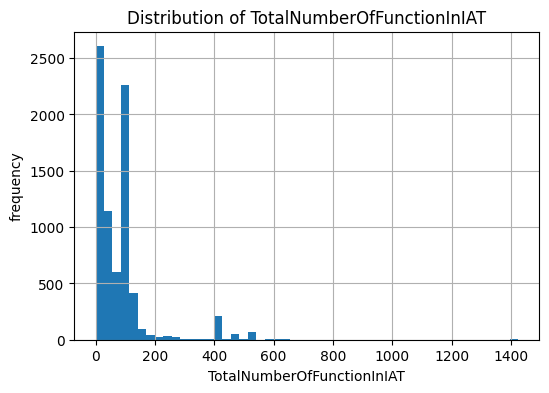

In [38]:
for feature in selected_feature_list:
    fig = plt.figure(figsize=(6, 4))
    total_df[feature].hist(bins=50)

    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.title('Distribution of ' + feature) 
    plt.savefig(f'../result/images/histogram_{feature}.png')

Feature & Category -> Box plot

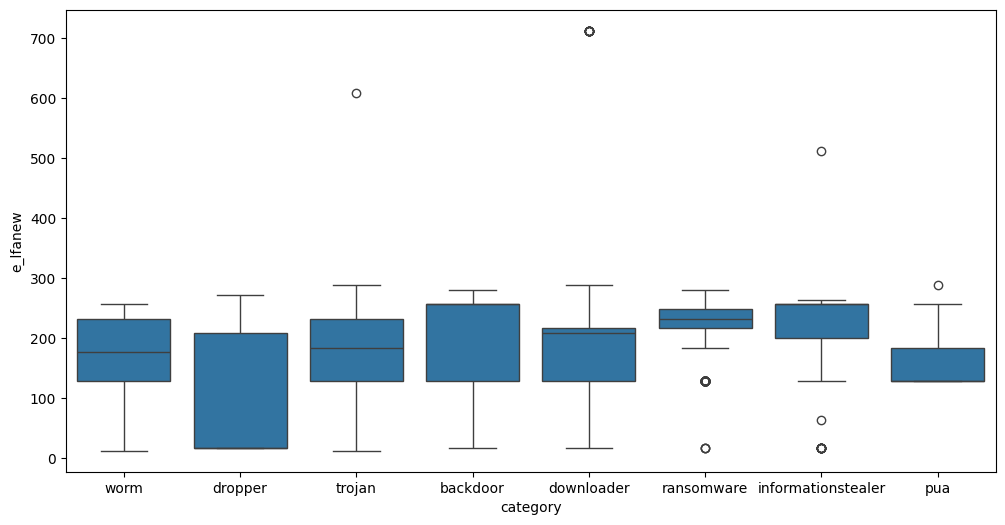

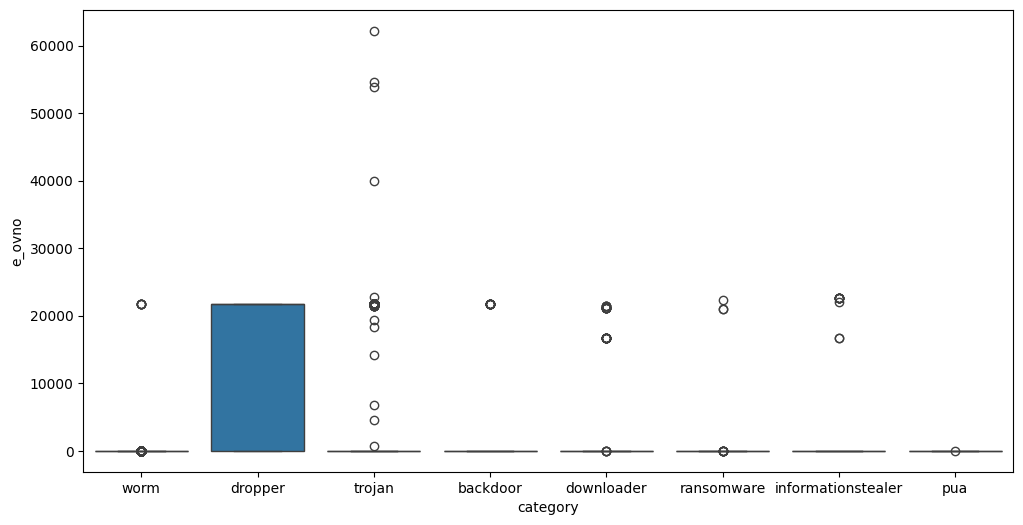

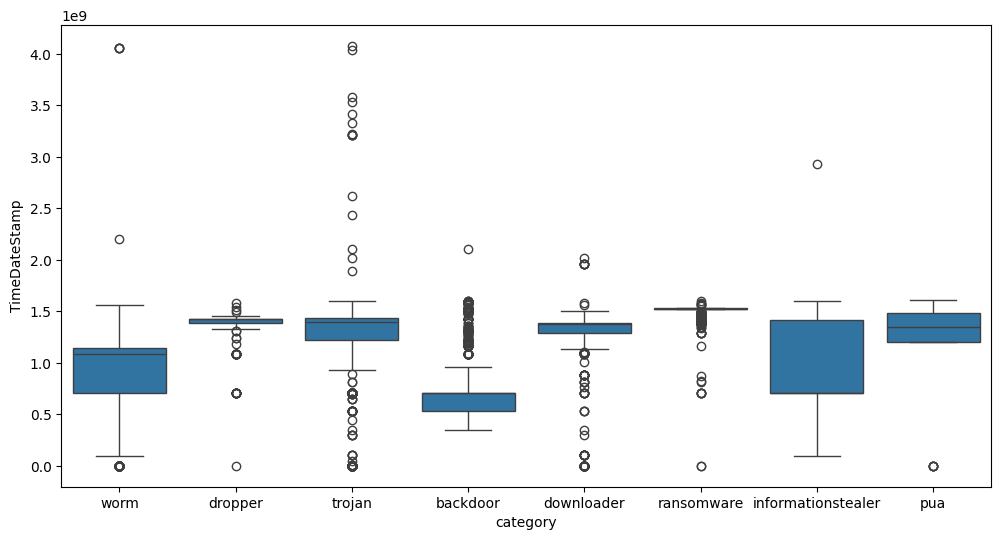

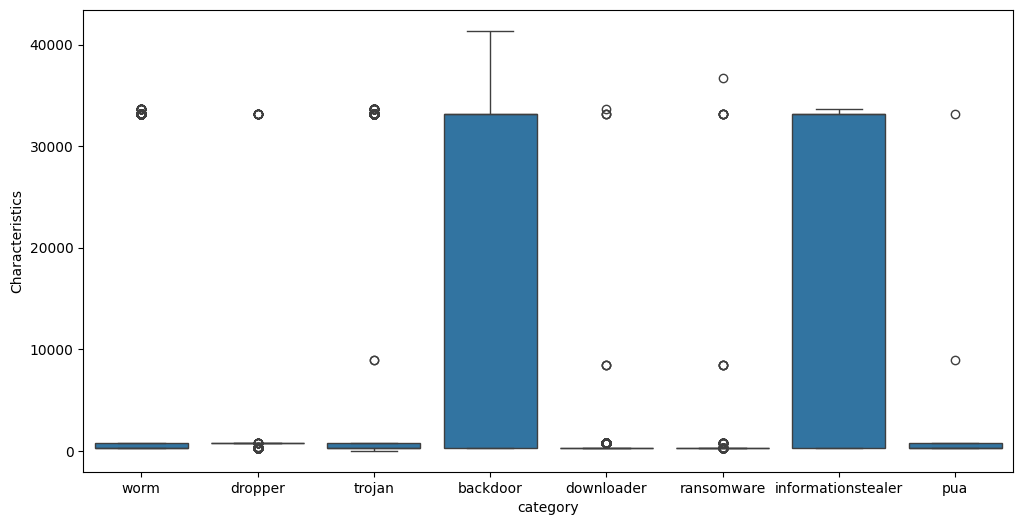

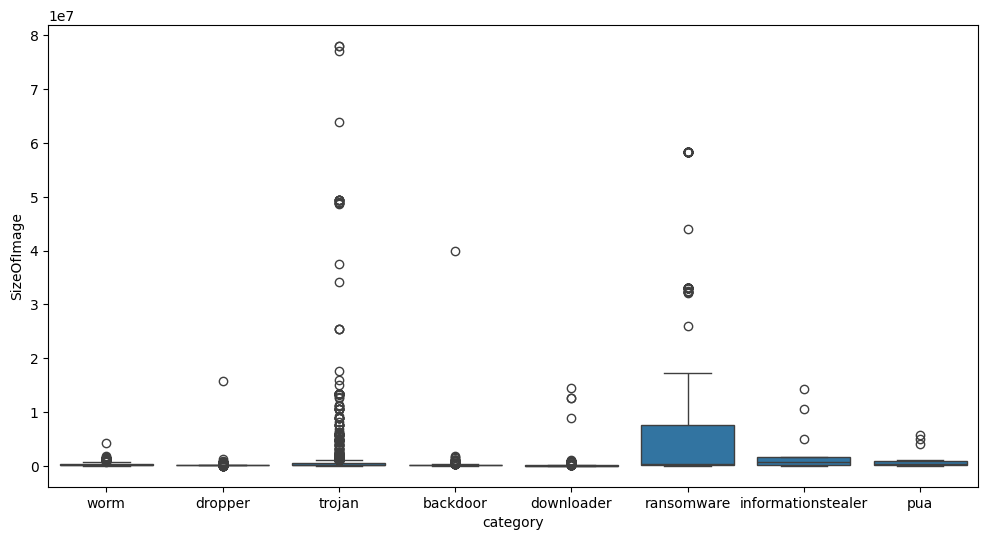

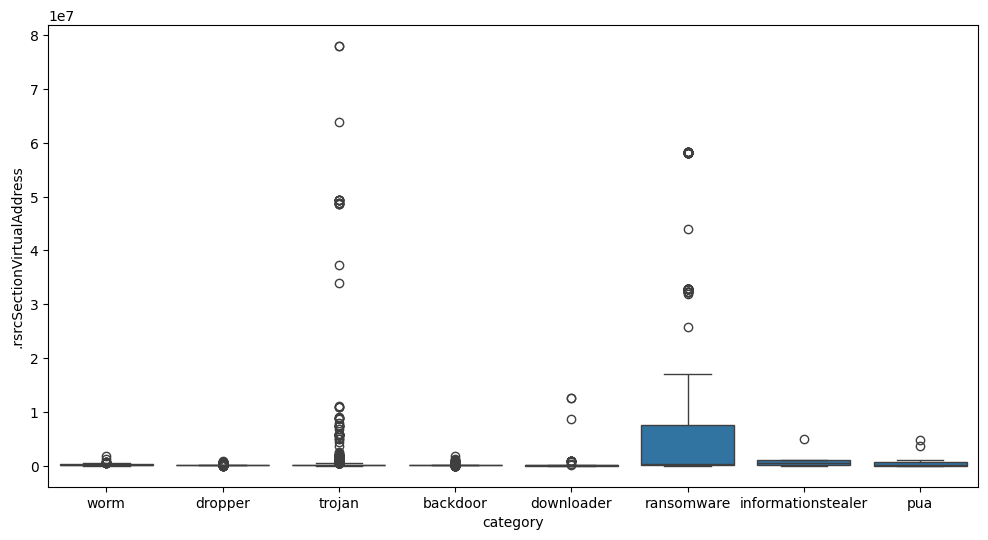

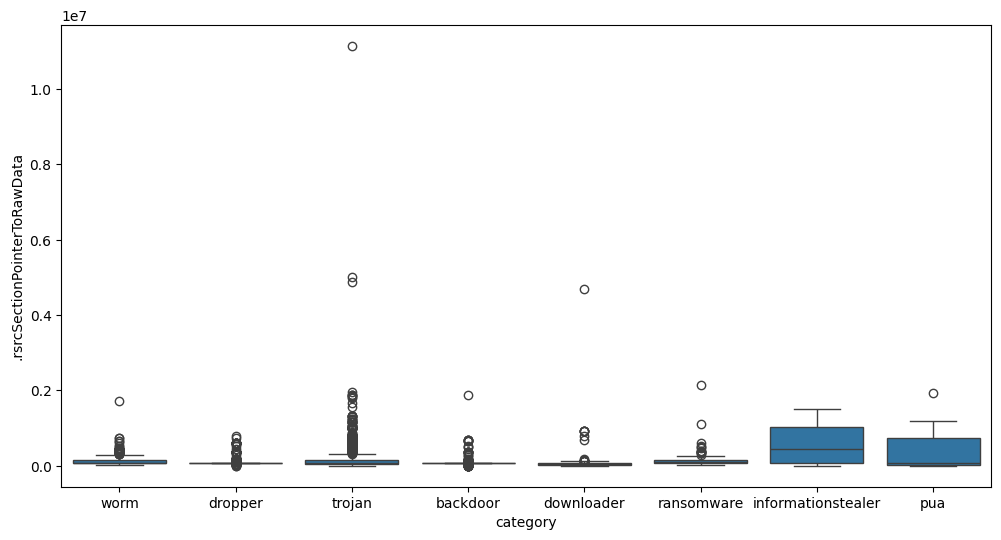

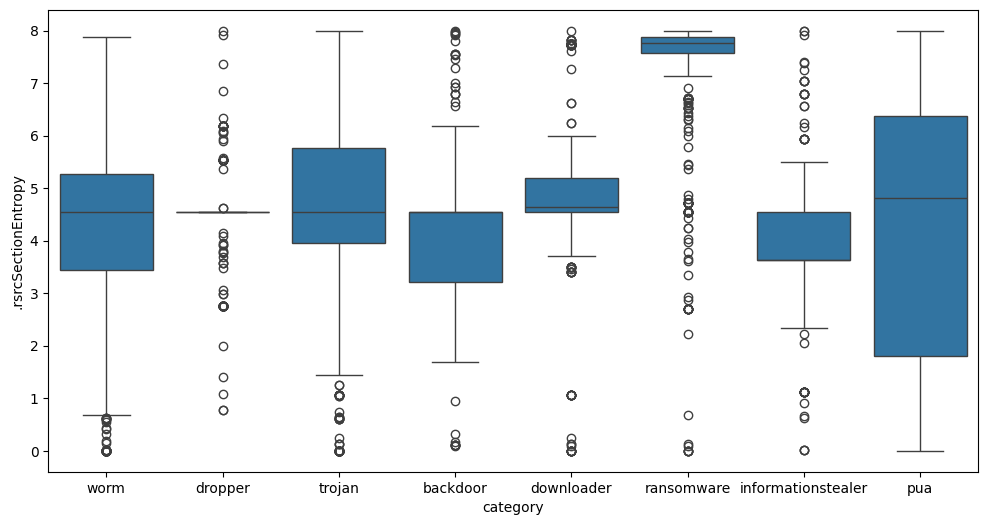

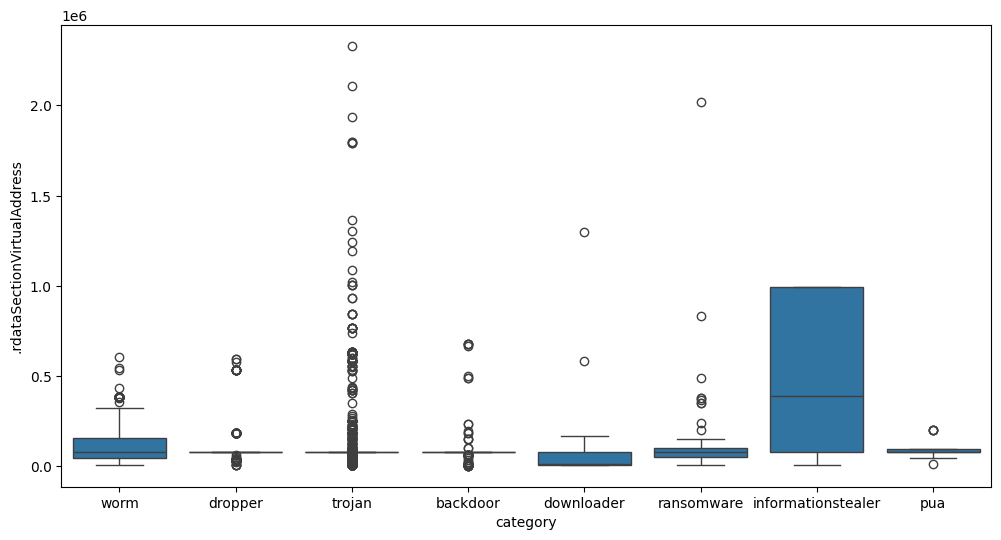

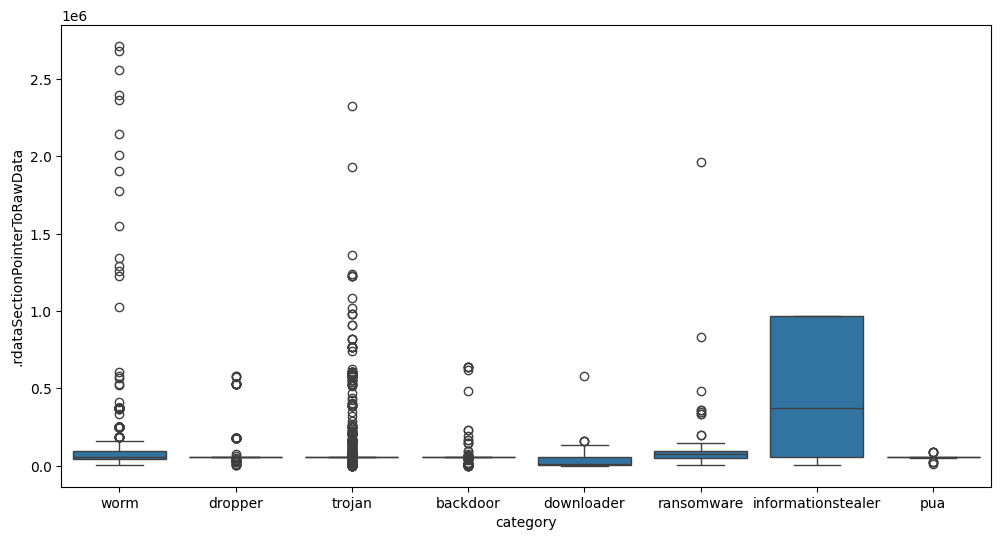

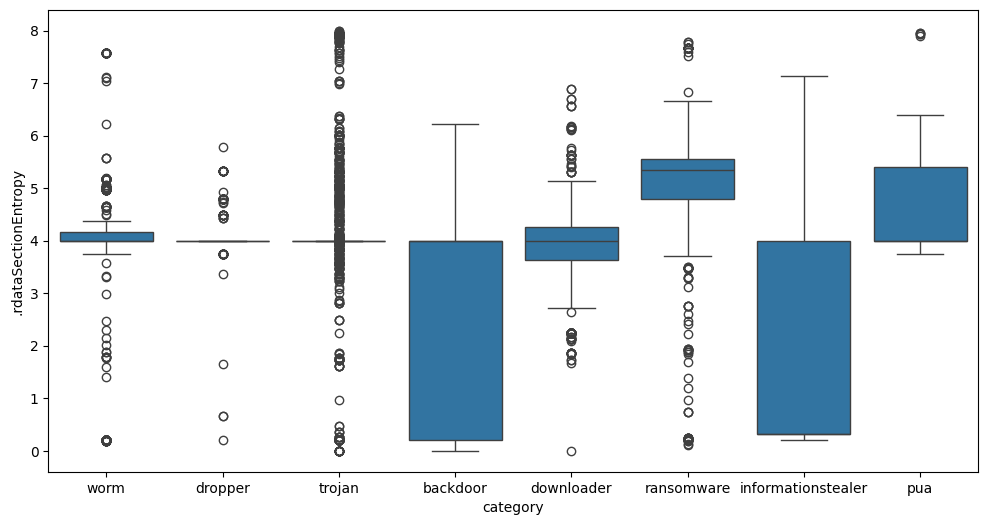

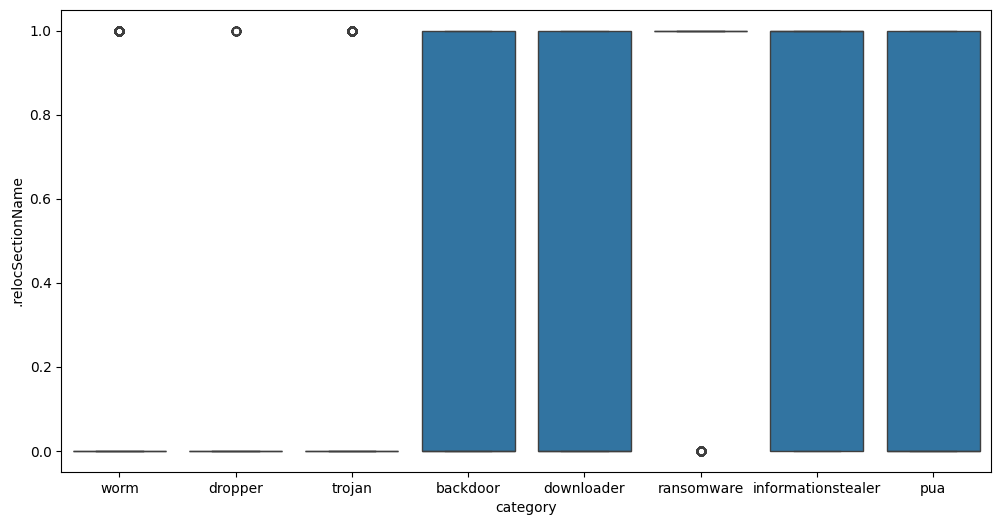

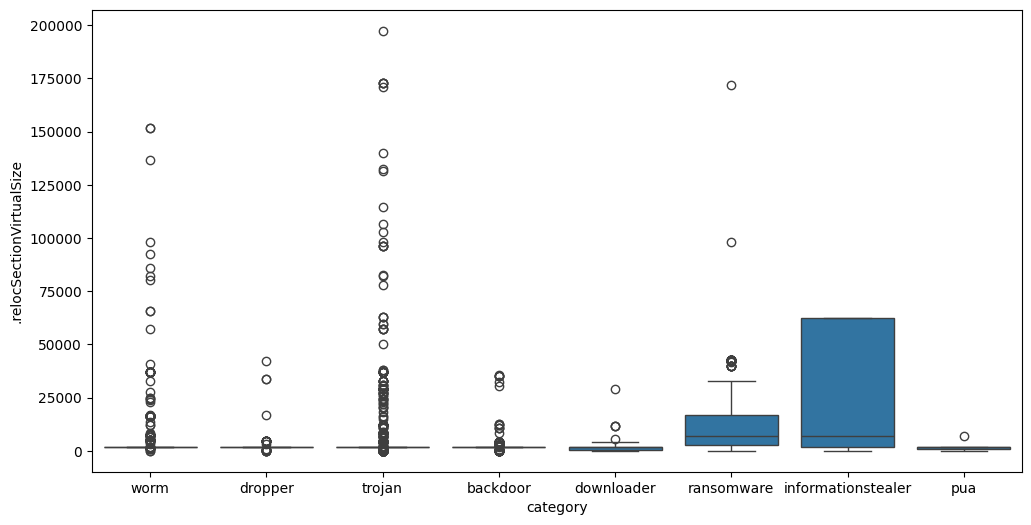

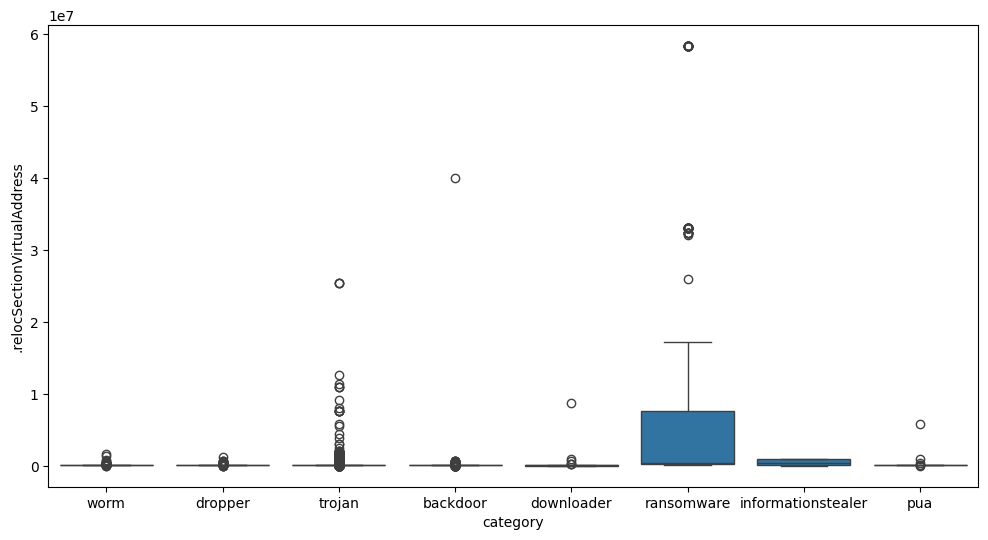

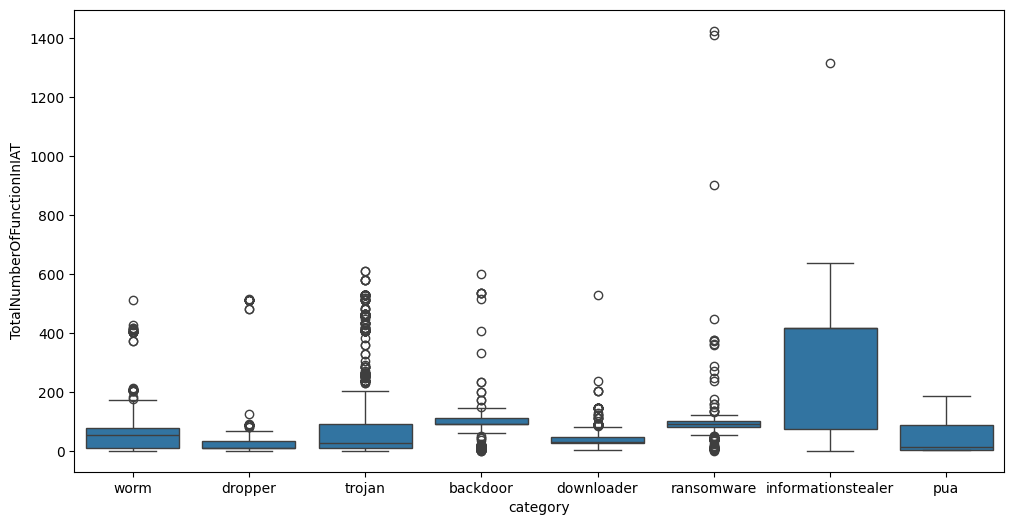

In [39]:
for feature in selected_feature_list:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y=feature, data=total_df)
    plt.savefig(f'../result/images/boxplot_{feature}.png')
    plt.show()

numerical feature - correlation

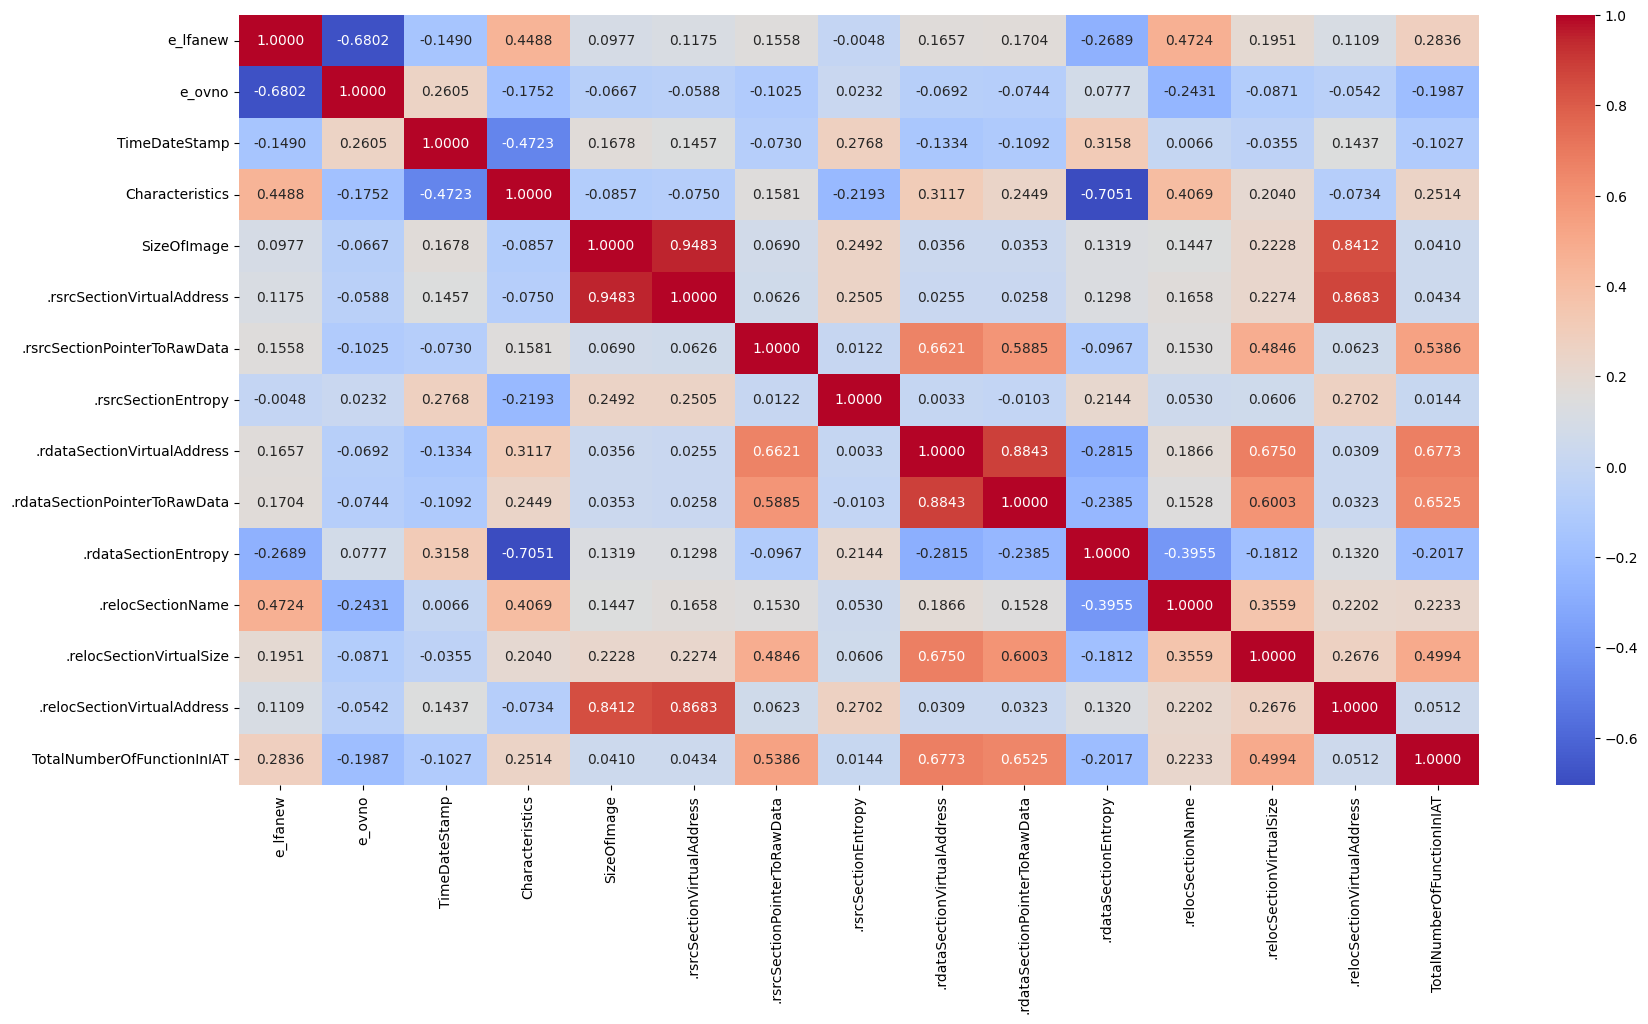

In [40]:
selected_numeric_feature_corr = total_df[selected_feature_list].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(selected_numeric_feature_corr, annot=True, fmt='.4f', cmap=plt.get_cmap('coolwarm'), cbar=True)
plt.savefig('../result/images/selected_feature_correlation.png', bbox_inches='tight', pad_inches=0.3)